In [1]:
from tda import auth, client
import json
from datetime import date
from json2table import convert
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd  

In [2]:
token_path = '/home/bsiranos/token.pickle'
api_key = 'QF5QJ3AQ0MU5MFEZHT5ESO362ERPWJ7I@AMER.OAUTHAP'
redirect_uri = 'https://localhost'
try:
    c = auth.client_from_token_file(token_path, api_key)
except FileNotFoundError:
    from selenium import webdriver
    with webdriver.Chrome() as driver:
        c = auth.client_from_login_flow(
            driver, api_key, redirect_uri, token_path)

In [3]:
resp = c.get_price_history('SPX',
        period_type=c.PriceHistory.PeriodType.YEAR,
        period=c.PriceHistory.Period.TWENTY_YEARS,
        frequency_type=c.PriceHistory.FrequencyType.DAILY,
        frequency=c.PriceHistory.Frequency.DAILY)
assert resp.ok
history = resp.json()
history

{'candles': [{'open': 1441.48,
   'high': 1459.66,
   'low': 1441.48,
   'close': 1455.25,
   'volume': 0,
   'datetime': 961995600000},
  {'open': 1455.3101,
   'high': 1463.4399,
   'low': 1450.5501,
   'close': 1450.5501,
   'volume': 0,
   'datetime': 962082000000},
  {'open': 1450.5501,
   'high': 1467.6,
   'low': 1450.5501,
   'close': 1454.82,
   'volume': 0,
   'datetime': 962168400000},
  {'open': 1454.82,
   'high': 1455.14,
   'low': 1434.63,
   'close': 1442.39,
   'volume': 0,
   'datetime': 962254800000},
  {'open': 1442.39,
   'high': 1454.68,
   'low': 1438.71,
   'close': 1454.6,
   'volume': 0,
   'datetime': 962341200000},
  {'open': 1454.6,
   'high': 1469.58,
   'low': 1450.85,
   'close': 1469.32,
   'volume': 0,
   'datetime': 962600400000},
  {'open': 1469.54,
   'high': 1469.54,
   'low': 1442.4499,
   'close': 1446.23,
   'volume': 0,
   'datetime': 962773200000},
  {'open': 1446.23,
   'high': 1461.65,
   'low': 1439.5601,
   'close': 1456.67,
   'volume': 0

In [4]:
# get OTM options
symbol = "$XSP.X"
symbol = "SPY"
resp = c.get_option_chain(symbol,
    contract_type=client.Client.Options.ContractType('ALL'), 
    strike_range = client.Client.Options.StrikeRange('OTM'), 
    strike_to_date=date(2020,7,24))
assert resp.ok
chain=resp.json()

In [5]:
exps = list(chain['callExpDateMap'].keys())
calls = chain['callExpDateMap']
puts = chain['putExpDateMap']



In [6]:
# variable for a particular strike
strike= 301.0
exps = list(calls.keys())
thetas = np.array(np.abs([calls[k][str(strike)][0]['theta'] for k in exps]))
marks = np.array([calls[k][str(strike)][0]['mark'] for k in exps])
dtes = np.array([calls[k][str(strike)][0]['daysToExpiration'] for k in exps])
ratio = thetas / marks
ratio

array([0.19246862, 0.13919753, 0.10906801, 0.08983051, 0.05311355,
       0.04376997, 0.03726619, 0.03057065, 0.02719298, 0.02453271,
       0.0214447 , 0.01963519, 0.01827515])

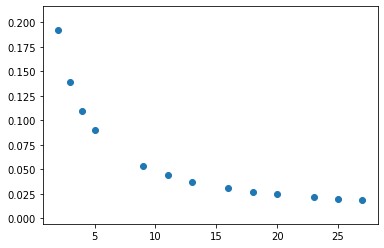

In [7]:
plt.scatter(dtes,ratio); plt.show()

In [8]:

# get best delta for a single expiration
def get_best_delta(call_exp, dt):
    strikes = list(call_exp.keys())
    deltas = np.array(np.abs([call_exp[strike][0]['delta'] for strike in strikes]))
    delta_arg = np.argmin(np.abs(deltas - dt))
    delta_value = deltas[delta_arg]
    delta_diff = delta_value - dt
    delta_strike = strikes[delta_arg]
    best_option = call_exp[delta_strike][0]
#     print(delta_arg)
#     print(delta_strike)
#     print(delta_value)
#     print(delta_diff)
#     if (best_option['mark'] > 0 and best_option['openInterest'] >0):
    if (best_option['mark'] > 0):
        return(best_option)

In [9]:
# for a given delta, find the option closest to it for each expiration
# and get the greeks
# delta target
dt = 0.1
exps = list(calls.keys())
best_options_calls = [get_best_delta(calls[exp], dt) for exp in exps]
best_options_calls = [b for b in best_options_calls if b is not None]
best_options_puts = [get_best_delta(puts[exp], dt) for exp in exps]
best_options_puts = [b for b in best_options_puts if b is not None]
underlying_price = chain["underlyingPrice"]


In [10]:
call_df = pd.DataFrame(best_options_calls)
put_df = pd.DataFrame(best_options_puts)

def calc_extra(df):
    df['thetaRatio'] = abs(df.loc[:, 'theta'] /df.loc[:, 'mark'])
    df['percentOTM'] = np.round(np.abs((underlying_price - df.loc[:, 'strikePrice']) /underlying_price * 100), 2)
    df['profitPerDay'] = df.loc[:, 'mark'] / df.loc[:, 'daysToExpiration']
    return(df)
call_df = calc_extra(call_df)
put_df = calc_extra(put_df)

In [11]:
call_df.columns

Index(['putCall', 'symbol', 'description', 'exchangeName', 'bid', 'ask',
       'last', 'mark', 'bidSize', 'askSize', 'bidAskSize', 'lastSize',
       'highPrice', 'lowPrice', 'openPrice', 'closePrice', 'totalVolume',
       'tradeDate', 'tradeTimeInLong', 'quoteTimeInLong', 'netChange',
       'volatility', 'delta', 'gamma', 'theta', 'vega', 'rho', 'openInterest',
       'timeValue', 'theoreticalOptionValue', 'theoreticalVolatility',
       'optionDeliverablesList', 'strikePrice', 'expirationDate',
       'daysToExpiration', 'expirationType', 'lastTradingDay', 'multiplier',
       'settlementType', 'deliverableNote', 'isIndexOption', 'percentChange',
       'markChange', 'markPercentChange', 'mini', 'inTheMoney', 'nonStandard',
       'thetaRatio', 'percentOTM', 'profitPerDay'],
      dtype='object')

In [12]:
pick_cols = ['daysToExpiration','strikePrice', 'mark', 'theta','gamma', 'thetaRatio', 'percentOTM', 'profitPerDay']
call_df.loc[:,pick_cols]

,daysToExpiration,strikePrice,mark,theta,gamma,thetaRatio,percentOTM,profitPerDay
0,2,307.0,0.32,-0.181,0.034,0.565625,2.29,0.160000
1,3,310.0,0.29,-0.142,0.022,0.489655,3.29,0.096667
2,4,311.0,0.42,-0.152,0.021,0.361905,3.62,0.105000
3,5,313.0,0.44,-0.138,0.018,0.313636,4.29,0.088000
4,9,315.0,0.49,-0.092,0.015,0.187755,4.95,0.054444
5,11,317.0,0.54,-0.085,0.014,0.157407,5.62,0.049091
6,13,318.0,0.65,-0.085,0.013,0.130769,5.95,0.050000
7,16,319.0,0.67,-0.073,0.012,0.108955,6.29,0.041875
8,18,320.0,0.76,-0.072,0.012,0.094737,6.62,0.042222
9,20,322.0,0.73,-0.065,0.011,0.089041,7.29,0.036500


In [13]:
put_df.loc[:, pick_cols]

,daysToExpiration,strikePrice,mark,theta,gamma,thetaRatio,percentOTM,profitPerDay
0,2,291.0,0.34,-0.209,0.024,0.614706,3.04,0.170000
1,3,288.0,0.50,-0.224,0.018,0.448000,4.04,0.166667
2,4,285.0,0.59,-0.216,0.014,0.366102,5.04,0.147500
3,5,282.0,0.70,-0.215,0.012,0.307143,6.04,0.140000
4,9,279.0,0.83,-0.152,0.010,0.183133,7.04,0.092222
5,11,275.0,0.97,-0.149,0.008,0.153608,8.37,0.088182
6,13,272.0,1.11,-0.145,0.007,0.130631,9.37,0.085385
7,16,270.0,1.18,-0.128,0.007,0.108475,10.04,0.073750
8,18,270.0,1.52,-0.136,0.007,0.089474,10.04,0.084444
9,20,265.0,1.43,-0.124,0.006,0.086713,11.71,0.071500


In [14]:
# So what's the best strategy for using the LEAPS covered strangle
# I feel that with current vol, actually moving to sooner expirations (weekly) might
# be better than the monthly strategy. 
# or start to stagger them within a week, etc.

# if I set a profit threshold - assuming holding to exp, 
# can look at the surface to see the combinations
# of delta and dte that will get there
# 

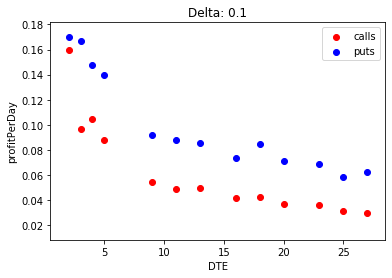

In [15]:
plt.scatter(call_df.loc[:,"daysToExpiration"],
            np.abs(call_df.loc[:, "profitPerDay"]), color='red')
plt.scatter(put_df.loc[:,"daysToExpiration"],
            np.abs(put_df.loc[:, "profitPerDay"]), color='blue')
plt.legend(['calls', 'puts'])
plt.xlabel('DTE')
plt.ylabel('profitPerDay')
plt.title('Delta: ' + str(dt))
plt.show()

In [16]:
# some function to convert all this data to a heatmap, dependent on greeks 
# convert to matrix of strikes by expirations
# and array for each of the greeks
# done for one of calls/puts
# def get_greek_matrix(options, greek):
greek='mark'
underlying_price = chain["underlyingPrice"]

options = calls
exps = list(options.keys())
dtes = [list(options[exp].items())[0][1][0]['daysToExpiration'] for exp in exps]
strikes = [list(o.keys()) for o in [options[exp] for exp in exps]]
strikes_set = list(set([item for sublist in strikes for item in sublist]))
strikes_set.sort()
strikeOTM = [np.abs(float(strike) - underlying_price) / underlying_price * 100 for strike in strikes_set]
# only look at things <10% otm
strikes_set = np.array(strikes_set)[np.where(np.array(strikeOTM) <= 10)]
df = pd.DataFrame(index=strikes_set, columns=exps)
df = df.fillna(0)
for exp in exps: 
    thisExp = options[exp]
    for strike in strikes_set:
        if strike in thisExp.keys():
            thisOpt = thisExp[strike][0]
            df.loc[strike, exp] = thisOpt[greek]
df = df.sort_index()  
greekMat = np.abs(pd.DataFrame.to_numpy(df))

In [17]:
df

,2020-06-29:2,2020-06-30:3,2020-07-01:4,2020-07-02:5,2020-07-06:9,2020-07-08:11,2020-07-10:13,2020-07-13:16,2020-07-15:18,2020-07-17:20,2020-07-20:23,2020-07-22:25,2020-07-24:27
301.0,2.39,3.24,3.97,4.72,5.46,6.26,6.95,7.36,7.98,8.56,8.86,9.32,9.74
302.0,1.88,2.68,3.40,4.14,4.88,5.67,6.36,6.76,7.38,7.96,8.25,8.71,9.13
303.0,1.42,2.18,2.88,3.61,4.33,5.12,5.79,6.19,6.79,7.37,7.67,8.12,8.54
304.0,1.02,1.73,2.40,3.09,3.81,4.58,5.25,5.63,6.23,6.80,7.10,7.54,7.96
305.0,0.72,1.34,1.96,2.63,3.32,4.07,4.72,5.10,5.68,6.24,6.54,6.98,7.40
306.0,0.48,1.02,1.58,2.19,2.87,3.59,4.22,4.60,5.16,5.71,6.00,6.44,6.85
307.0,0.32,0.76,1.25,1.82,2.46,3.14,3.75,4.12,4.67,5.21,5.49,5.91,6.32
308.0,0.21,0.56,0.97,1.49,2.07,2.73,3.31,3.66,4.19,4.71,4.99,5.41,5.82
309.0,0.14,0.41,0.74,1.19,1.73,2.34,2.89,3.23,3.75,4.25,4.52,4.93,5.33
310.0,0.09,0.29,0.56,0.94,1.43,2.00,2.51,2.84,3.32,3.81,4.07,4.47,4.86


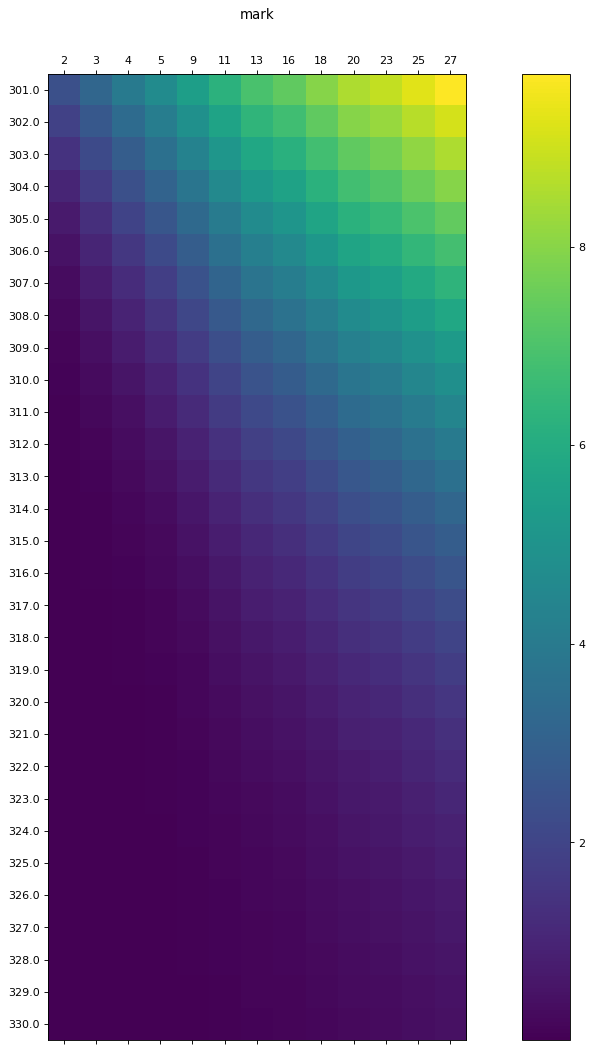

In [18]:
from matplotlib.colors import LogNorm
# fig = plt.figure()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
# cax = ax.matshow(greekMat, norm=LogNorm(vmin=0.01, vmax=10))
cax = ax.matshow(greekMat)
cbar = fig.colorbar(cax)
dteLabs = [str(dte) for dte in dtes]
strikeLabs = [str(strike) for strike in strikes_set]
ax.set_xticklabels(['']+ dteLabs)
ax.set_yticklabels(['']+ strikeLabs)
ax.set_title(greek)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [19]:
dteLabs

['2', '3', '4', '5', '9', '11', '13', '16', '18', '20', '23', '25', '27']

In [ ]:
import ipywidgets as widgets

In [433]:
w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [436]:
w.value
w.value=200